In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip instll opencv-python

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "instll" - maybe you meant "install"



In [6]:
%pip install scikit-image

   ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
   -------------------------------- ------- 10.5/12.8 MB 50.4 MB/s eta 0:00:01
   ---------------------------------------- 12.8/12.8 MB 47.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import cv2  #opency-pyton 모듈 설치
import glob
import json
import shutil
import random
import ultralytics
import torch
import yaml
import ultralytics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.datasets import ImageFolder
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
%matplotlib inline

In [2]:
data_root = r'E:\project\New_Data'
file_root = rf'{data_root}\Image'
project_name = 'fall_detection'
print(file_root)
train_root = rf'{data_root}\train'
valid_root = rf'{data_root}\valid'
test_root = rf'{data_root}\test'
cls_list = ['Normal', 'Fall']
cls_filename_list = ['N', 'BY', 'FY', 'SY']

E:\project\New_Data\Image


In [ ]:
# train_valid_test_split
for cls in cls_filename_list:    
    file_list = glob.glob(f'{file_root}\\labels\\*_{cls}_*.txt')
    file_group_list = list(set([i.split('\\')[-1].split('_')[0] for i in file_list]))
    print(file_group_list)
    print(len(file_group_list))
    random.shuffle(file_group_list)
    test_ratio = 0.1
    num_file = len(file_group_list)

    test_list = file_group_list[:int(num_file*test_ratio)]
    valid_list = file_group_list[int(num_file*test_ratio):int(num_file*test_ratio)*2]
    train_list = file_group_list[int(num_file*test_ratio)*2:]


    for i in tqdm(train_list):
        for src in glob.glob(f'{file_root}\\labels\\{i}_*.txt'):
            label_name = src.split('\\')[-1]
            shutil.copyfile(src, f'{train_root}\\labels\\{label_name}')
            img_name = label_name.split('//')[-1].replace('txt', 'jpg')
            img_path = f'{file_root}\\images\\{img_name}'
            shutil.copyfile(img_path, f'{train_root}\\images\\{img_name}')

    for i in tqdm(test_list):
        for src in glob.glob(f'{file_root}\\labels\\{i}_*.txt'):
            label_name = src.split('\\')[-1]
            shutil.copyfile(src, f'{test_root}\\labels\\{label_name}')
            img_name = label_name.split('//')[-1].replace('txt', 'jpg')
            img_path = f'{file_root}\\images\\{img_name}'
            shutil.copyfile(img_path, f'{test_root}\\images\\{img_name}')

    for i in tqdm(valid_list):
        for src in glob.glob(f'{file_root}\\labels\\{i}_*.txt'):
            label_name = src.split('\\')[-1]
            shutil.copyfile(src, f'{valid_root}\\labels\\{label_name}')
            img_name = label_name.split('//')[-1].replace('txt', 'jpg')
            img_path = f'{file_root}\\images\\{img_name}'
            shutil.copyfile(img_path, f'{valid_root}\\images\\{img_name}')

# with open(f'{data_root}\\train_list', 'w') as f:
#     f.write(train_list)
# with open(f'{data_root}\\test_list', 'w') as f:
#     f.write(test_list)
# with open(f'{data_root}\\valid_list', 'w') as f:
#     f.write(valid_list)


In [6]:
print('train: ', len(os.listdir(f'{train_root}/images')))
print('test: ', len(os.listdir(f'{test_root}/images')))
print('valid: ', len(os.listdir(f'{valid_root}/images')))

train:  67840
test:  8240
valid:  8170


In [3]:
data = dict()

data['train'] = train_root
data['val'] = valid_root
data['test'] = test_root
data['nc'] = len(cls_list)
data['names'] = cls_list

with open(f'{data_root}/detect.yaml', 'w') as f:
    yaml.dump(data, f)

In [4]:
# yolo 객체 만들기
%cd E:\project\New_Data
# 기존의 yolov8s/n/m/... ==> segmentation 미지원
# model = YOLO('yolov8s-seg.yaml') ==> 모델의 구조와 설정을 정의하는 파일, 처음부터 학습
model = YOLO('yolov8n') # ==> 기존의 학습된 모델을 사용
model_seg = YOLO('yolov8n-seg')

E:\project\New_Data


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
test_file_list = glob.glob(f'{test_root}\\images\\*')
print(len(test_file_list))

color_dict = {i: tuple([random.randint(0, 255) for _ in range(3)]) for i in range(len(model.names))}
color_dict

8240


{0: (248, 94, 237),
 1: (204, 80, 111),
 2: (180, 53, 137),
 3: (62, 246, 179),
 4: (150, 36, 193),
 5: (11, 253, 247),
 6: (253, 220, 122),
 7: (221, 200, 248),
 8: (56, 161, 221),
 9: (189, 112, 192),
 10: (143, 86, 126),
 11: (253, 105, 32),
 12: (185, 58, 97),
 13: (26, 156, 35),
 14: (92, 228, 33),
 15: (27, 94, 234),
 16: (208, 111, 143),
 17: (177, 60, 170),
 18: (132, 91, 229),
 19: (71, 162, 240),
 20: (229, 125, 131),
 21: (68, 36, 37),
 22: (58, 105, 85),
 23: (212, 204, 61),
 24: (43, 140, 9),
 25: (114, 80, 205),
 26: (133, 18, 28),
 27: (69, 77, 172),
 28: (158, 228, 251),
 29: (226, 160, 97),
 30: (16, 218, 105),
 31: (152, 188, 149),
 32: (169, 208, 17),
 33: (227, 127, 86),
 34: (83, 156, 39),
 35: (102, 233, 86),
 36: (77, 48, 77),
 37: (192, 98, 195),
 38: (111, 100, 82),
 39: (232, 192, 144),
 40: (219, 120, 26),
 41: (29, 85, 246),
 42: (108, 178, 6),
 43: (164, 249, 193),
 44: (188, 169, 90),
 45: (151, 35, 27),
 46: (7, 236, 251),
 47: (8, 225, 102),
 48: (204, 2


0: 640x640 1 person, 1 couch, 4 potted plants, 10.0ms
Speed: 179.1ms preprocess, 10.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 couchs, 3 potted plants, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 couch, 3 potted plants, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 couch, 3 potted plants, 4.0ms
Speed: 1.0ms preprocess, 4.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 1 couch, 3 potted plants, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 2 couchs, 3 potted plants, 4.5ms
Speed: 1.0ms preprocess, 4.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 couch, 3 potted plants, 1 teddy bear, 4.3ms
Speed: 1.0ms preprocess, 4.3ms infer

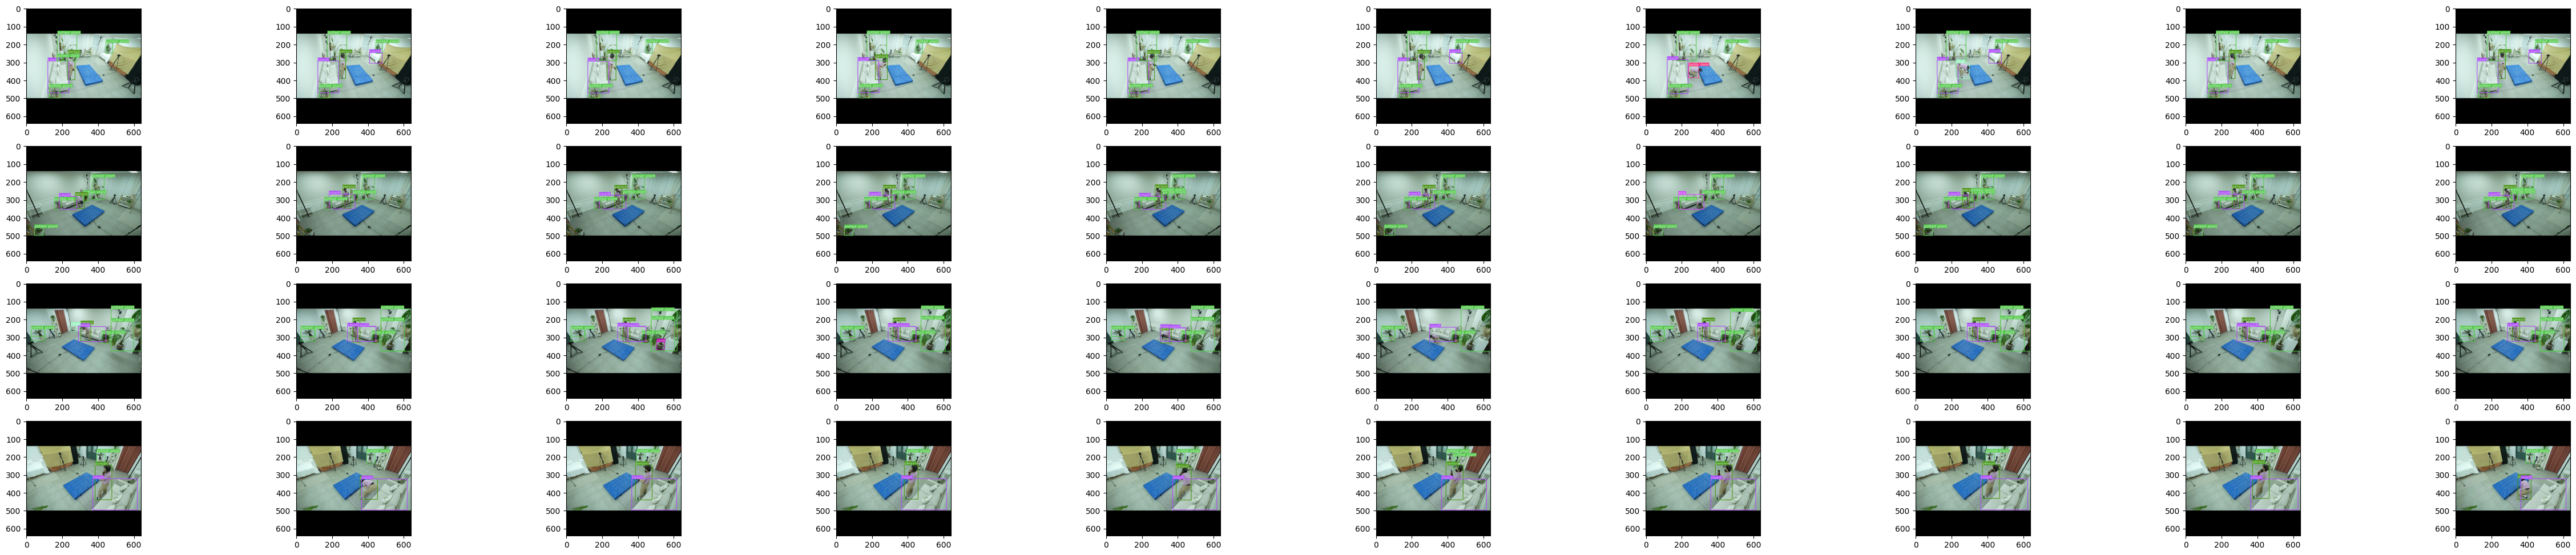

In [16]:

plt.figure(figsize=(60, 12))

for idx in range(40):
    num_head = 0
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]

    annotator = Annotator(img_src)
    boxes = result.boxes

    for box in boxes:
        b = box.xyxy[0]
        cls = box.cls
        annotator.box_label(b, model.names[int(cls)], color_dict[int(cls)])
    img_src = annotator.result()

    plt.subplot(4, 10, (idx+1))

    plt.imshow(img_src)
plt.show()

In [7]:
import skimage
from skimage.draw import polygon2mask

plt.figure(figsize=(60, 12))

for idx in range(40):    
    test_img = cv2.imread(test_file_list[idx])
    img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    result = model(img_src)[0]
    result_mask = np.zeros(test_img.shape[:2])
    masks = result.masks
    print(type(masks))

    for m in masks:
        polygon_coor = m.xy[0]
        mask = polygon2mask(test_img.shape[:2], polygon_coor)
        result_mask = np.maximum(mask, result_mask)
    result_mask = np.repeat(result_mask[:, :, np.newaxis], 3, -1)

    plt.subplot(4, 10, (idx+1))
    plt.imshow(result_mask)
plt.show()


0: 640x640 1 person, 1 couch, 4 potted plants, 4.0ms
Speed: 3.0ms preprocess, 4.0ms inference, 67.8ms postprocess per image at shape (1, 3, 640, 640)
<class 'NoneType'>


TypeError: 'NoneType' object is not iterable

<Figure size 6000x1200 with 0 Axes>

In [10]:
test_img = cv2.imread(test_file_list[0])
img_src = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
result = model(img_src)[0]
result


0: 640x640 1 person, 1 couch, 4 potted plants, 216.1ms
Speed: 2.0ms preprocess, 216.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant',